# Predicción de categoria de productos

### Links

- [Text Classification with BERT in PyTorch](https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f)
- [BERT models](https://huggingface.co/models)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../src')

from matplotlib import pyplot as plt
import seaborn as sns

import numpy  as np
import pandas as pd

import torch
from   torch import nn
from   torch.optim import Adam
    
import logging

import random

import data  as dt
import model as ml
import util  as ut
import pytorch_common.util as pu

## Setup

Se configura el default logger para que la consola sea el output y loguee mensajes a partir del nivel INFO.

In [3]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

Por defecto usamos GPU. De no existir este hardware, el fallback es CPU:

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.__version__

'1.12.1+cu116'

In [6]:
pu.set_device_name('gpu')

logging.info(pu.get_device())

2022-09-21 17:29:40,923 - INFO - cuda:0


In [7]:
torch.cuda.get_arch_list()

['sm_37', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86']

## Funciones Helper

In [8]:
def set_seed(value):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)

label_by_class = lambda df: {row['branch_seq']: row['branch'] for _, row in df[['branch_seq', 'branch']].drop_duplicates().iterrows() }

## Parametros

Fijamos la semilla para todas las librerias:

In [9]:
set_seed(42)

Definimos el modelo BERT preentrenado a utilizar. Este es una capa/module mas de nuestro modelo.

In [10]:
# BERT_MODEL ='bert-base-cased'
BERT_MODEL = 'bert-large-uncased'
# BERT_MODEL ='distilbert-base-uncased'

Definimos los paths del dataset y pesos del modelo:

In [11]:
DATASET_PATH       = '../../datasets/fashion-outfits'
IMAGES_PATH        = '../../datasets/fashion-outfits/images'
WEIGHTS_PATH       = '../../weights'
MODEL_WEIGHTS_PATH = f'{WEIGHTS_PATH}/{BERT_MODEL}.h5'

In [12]:
TRAIN = True

In [13]:
!mkdir -p {WEIGHTS_PATH}

## Cargar dataset

In [14]:
train_set = pd.read_csv(f'{DATASET_PATH}/train.csv').drop_duplicates()
val_set   = pd.read_csv(f'{DATASET_PATH}/val.csv').drop_duplicates()
test_set  = pd.read_csv(f'{DATASET_PATH}/test.csv').drop_duplicates()

Nota: Por alguna randon tenemos algun valor lon en la description. Revisar?

In [15]:
train_set.head()

,id,family,category,sub_category,description,highlights,brand,gender,materials,branch,tokens_count,image_uri,branch_seq
0,18182452,clothing,denim,wide-leg jeans,"dark wash wide-leg jeans unisex . Cotton . d, a,","[dark blue, cotton, dark wash, contrast stitch...",société anonyme,unisex,['Cotton'],clothing~denim~wide-leg jeans,11,18/18/24/52/18182452.jpg,27
1,13618632,clothing,denim,cropped jeans,Stovepipe denim cropped jeans women . Polyeste...,NaN,re/done,women,['Polyester' 'Cotton' 'Spandex/Elastane'],clothing~denim~cropped jeans,11,13/61/86/32/13618632.jpg,21
2,16988456,jewellery,bracelets,n/d,"shimmering bangle bracelet women . metal . s, i,","[silver-tone, metal, textured detail, lobster ...",brunello cucinelli,women,['metal'],jewellery~bracelets~n/d,10,16/98/84/56/16988456.jpg,94
3,16468253,clothing,jackets,blazers,"single-button tailored blazer women . viscose,...","[white, silk-blend, tailored cut, wide peak la...",giorgio armani,women,['viscose' 'Silk' 'Polyester'],clothing~jackets~blazers,12,16/46/82/53/16468253.jpg,31
4,16799130,clothing,skirts,pleated skirts,"feather-trim skirt women . Ostrich Feather, Sp...","[white, ostrich feather, feather detailing, fu...",styland,women,['Ostrich Feather' 'Spandex/Elastane' 'Polyest...,clothing~skirts~pleated skirts,12,16/79/91/30/16799130.jpg,65


In [16]:
train_set['description'] = train_set['description'].apply(str)
val_set  ['description'] = val_set  ['description'].apply(str)
test_set ['description'] = test_set ['description'].apply(str)

Tamaño máximo de la secuencia de entrada:

In [17]:
max_length = 2 + train_set['tokens_count'].max()
max_length

36

Definimos el tokenizer y los dataset para tran, validation y test:

In [18]:
tokenizer     = ml.Tokenizer(BERT_MODEL, padding = 'max_length', max_length = max_length)

In [19]:
train_dataset = dt.BertDataset(train_set, feature_col = 'description', target_col = 'branch_seq', tokenizer = tokenizer)
val_dataset   = dt.BertDataset(val_set,   feature_col = 'description', target_col = 'branch_seq', tokenizer = tokenizer)
test_dataset  = dt.BertDataset(test_set,  feature_col = 'description', target_col = 'branch_seq', tokenizer = tokenizer)

## Preparando el modelo

Cantidad de clases a predecir:

In [20]:
len(train_set['branch_seq'].unique())

107

In [21]:
n_classes = train_set['branch_seq'].max() + 1
n_classes

107

In [22]:
classifier = ml.BertClassifier(output_dim = n_classes, model = BERT_MODEL, dropout = 0, hiden_state_dim= 1024)

## Entrenamiento

In [23]:
model = ml.BertModel(classifier, batch_size = 10, criterion = nn.CrossEntropyLoss())

In [34]:
LR     = 0.00001
EPOCHS = 1

if TRAIN:
    model.fit(
        train_dataset, 
        val_dataset = val_dataset,
        optimizer   = Adam(classifier.parameters(), lr = LR),
        epochs      = EPOCHS
    )

2022-09-21 18:28:25,994 - INFO - Time: 0:16:52.72 | Epoch: 1 | Train(loss: 0.062799, acc: 81.39%) | Val(loss: 0.066468, acc: 80.06%) | acc diff: 1.33%


In [35]:
if TRAIN:
    classifier.save(MODEL_WEIGHTS_PATH)

## Evaluación

In [36]:
classifier.load(MODEL_WEIGHTS_PATH)

In [37]:
summary = model.validate(test_dataset)
summary.show()

Accuracy: 79.98%, Loss: 0.069121


<Figure size 2500x2500 with 2 Axes>

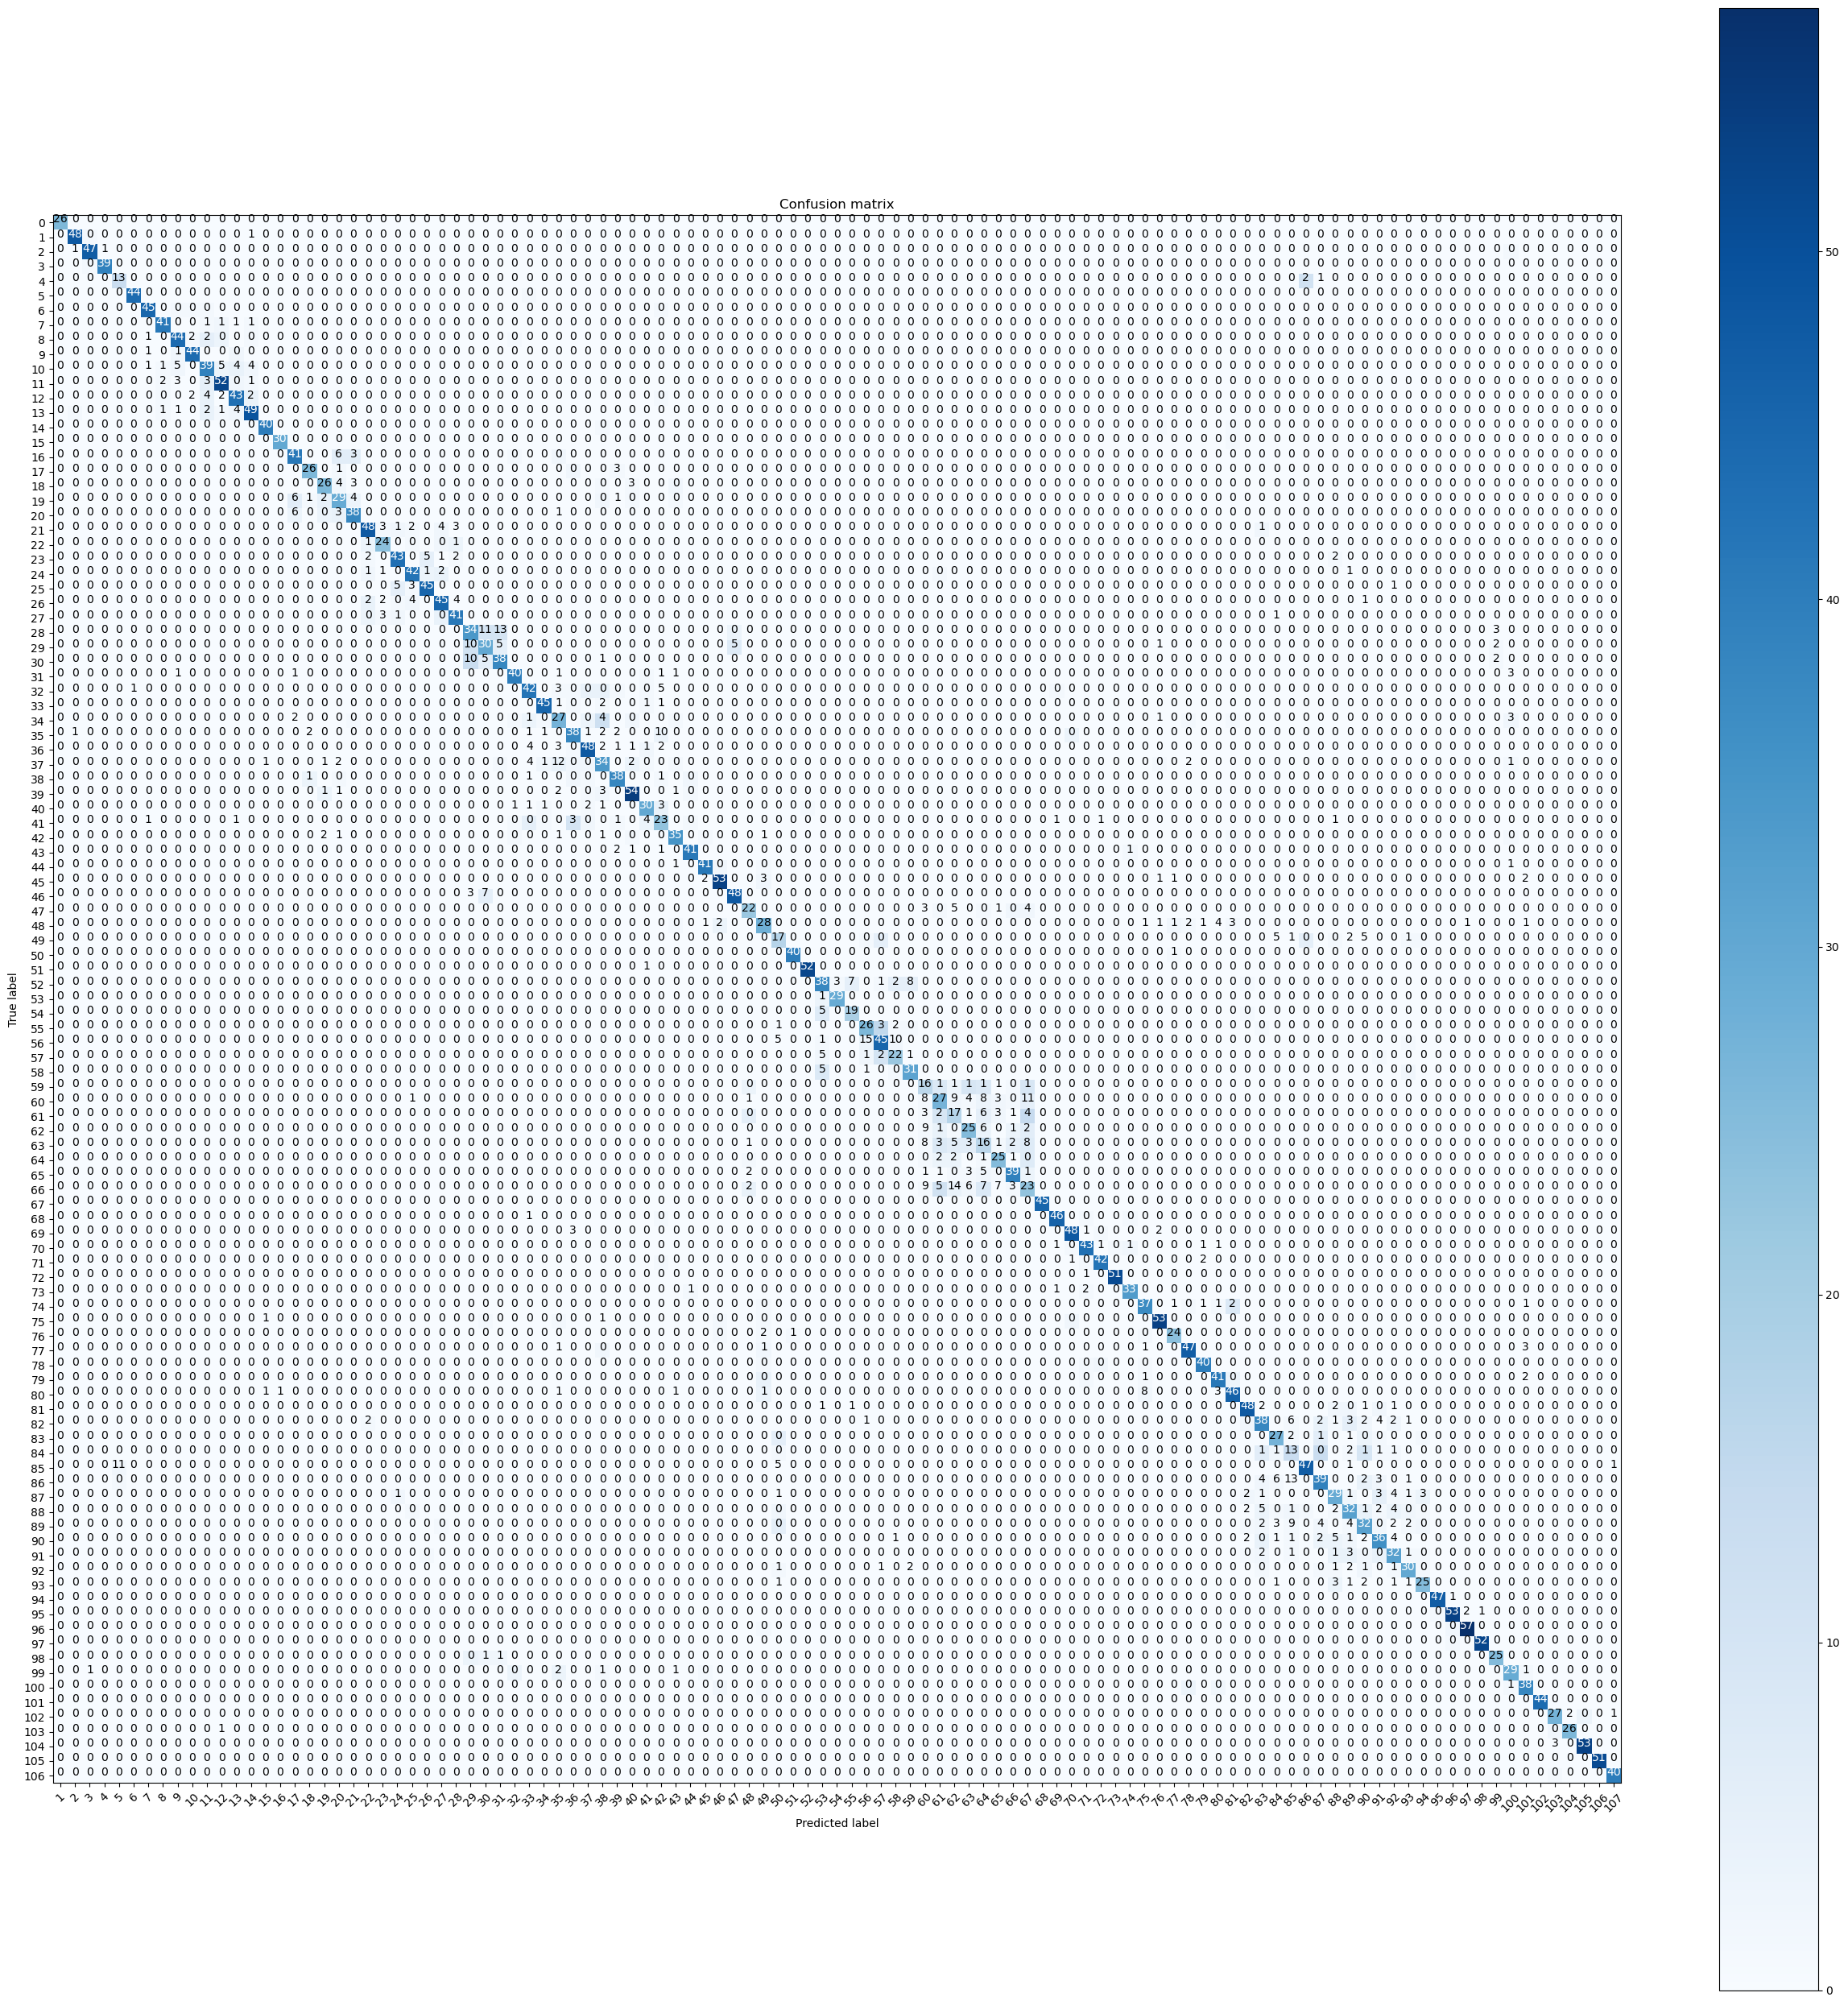

                                                      precision    recall  f1-score   support

                               accessories~belts~n/d       1.00      1.00      1.00        26
                                accessories~hats~n/d       0.98      0.96      0.97        50
                             accessories~scarves~n/d       0.96      0.98      0.97        48
                          accessories~sunglasses~n/d       1.00      0.97      0.99        40
activewear~performance trousers~performance leggings       0.81      0.54      0.65        24
                                  bags~backpacks~n/d       1.00      0.98      0.99        45
                                  bags~belt bags~n/d       1.00      0.92      0.96        49
                                bags~bucket bags~n/d       0.91      0.91      0.91        45
                                bags~clutch bags~n/d       0.90      0.80      0.85        55
                             bags~messenger bags~n/d       

In [38]:
# summary.show_sample_metrics(0)
result = summary.plot_metrics(label_by_class = label_by_class(train_set))

In [29]:
report_generator = ml.FailReportGenerator(
    tokenizer, 
    test_set, 
    test_dataset, 
    summary.targets, 
    summary.predictions,
    IMAGES_PATH
)

report = report_generator()

report.to_csv(f'{DATASET_PATH}/bet-model-fail-report.csv', index=False)

Total Fails: 20.95%


Ahora filtramos el reporte solo para aquellas clases que tiene un F1Score menor al 69%:

In [30]:
worts_classes = [
    'clothing~coats~oversized coats',
    'clothing~coats~single breasted coats',
    'clothing~dresses~cocktail & party dresses',
    'clothing~dresses~day dresses',
    'clothing~dresses~evening dresses',
    'clothing~jackets~cropped jackets',
    'clothing~jackets~fitted jackets',
    'clothing~jackets~lightweight jackets',
    'clothing~jackets~oversized jackets',
    'clothing~jackets~sport jackets & windbreakers',
    'clothing~knitwear~knitted skirts',
    'clothing~shorts~knee-length shorts',
    'clothing~shorts~tailored shorts',
    'clothing~skirts~asymmetric & draped skirts',
    'clothing~skirts~fitted skirts',
    'clothing~skirts~full skirts',
    'clothing~skirts~high-waisted skirts',
    'clothing~skirts~pencil skirts',
    'clothing~skirts~straight skirts',
    'clothing~trousers~flared trousers',
    'clothing~trousers~high-waisted trousers',
    'clothing~trousers~regular & straight-leg trousers',
    'clothing~trousers~skinny trousers',
    'clothing~trousers~slim-fit trousers',
    'clothing~trousers~straight trousers'
]               
                
report = report[report['true_class'].isin(worts_classes)].reset_index(drop=True)

In [31]:
report.shape, test_set.shape

((448, 5), (4944, 13))

In [32]:
ut.display_html(report)

,description,true_class,true_image,pred_class,pred_image
0,"textured - tweed mini skirt women. cotton, viscose, polyamide. w, h,",clothing~skirts~asymmetric & draped skirts,,clothing~skirts~fitted skirts,
1,"drawstring tailored trousers women. viscose, virgin wool, spandex / elastane, polyester. g, r,",clothing~trousers~high-waisted trousers,,clothing~trousers~tailored trousers,
2,"mark slim - cut tailored trousers women. wool, cupro. b, l,",clothing~trousers~slim-fit trousers,,clothing~trousers~tailored trousers,
3,"boy oversized trucker jacket women. cotton. v, i,",clothing~jackets~oversized jackets,,clothing~jackets~denim jackets,
4,"plaid print skorts women. viscose, wool, polyamide, acrylic, metallic fibre. b, e,",clothing~shorts~tailored shorts,,clothing~shorts~knee-length shorts,
5,"contrast stitching skirt women. cotton. t, o,",clothing~skirts~straight skirts,,clothing~skirts~high-waisted skirts,
6,"smocked waist tiered skirt women. polyamide, viscose. g, o,",clothing~skirts~high-waisted skirts,,clothing~skirts~full skirts,
7,"floral - print pleated skirt women. polyester. i, v,",clothing~skirts~full skirts,,clothing~skirts~pleated skirts,
8,"sequinned pleated midi skirt women. silk. g, o,",clothing~skirts~high-waisted skirts,,clothing~skirts~pleated skirts,
9,"cropped sleeveless jacket women. cotton. m, u,",clothing~jackets~fitted jackets,,clothing~jackets~waistcoat & gilets,
